In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pmdarima as pm
import scipy
import hvplot
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

import warnings

warnings.filterwarnings("ignore")

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.head()

,dt,MW
0,2011-01-01 00:00:00,3416.0
1,2011-01-01 00:15:00,4755.0
2,2011-01-01 00:30:00,4939.0
3,2011-01-01 00:45:00,4939.0
4,2011-01-01 01:00:00,4998.0


In [5]:
data.describe()

,MW
count,385566.000000
mean,3183.560481
std,3045.941591
min,0.000000
25%,905.000000
50%,2164.000000
75%,4529.877500
max,16727.500000


In [6]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [7]:
def get_prep_data(data_file, col, index_col):
    data = pd.read_csv(data_file, index_col=index_col, parse_dates=True)
    data.index.name = None
    data = data[[col]]
    data = data.ffill()
    return data

In [8]:
df = get_prep_data('data.csv', 'MW', 'dt')
df.columns = ['y']
df.head()

,y
2011-01-01 00:00:00,3416.0
2011-01-01 00:15:00,4755.0
2011-01-01 00:30:00,4939.0
2011-01-01 00:45:00,4939.0
2011-01-01 01:00:00,4998.0


In [9]:
df.index = pd.to_datetime(df.index)
df["hour"] = df.index.hour
df["day"] = df.index.day
df["weekday"] = df.index.weekday
df['is_weekend'] = df.weekday.isin([5,6])*1
df.tail()

,y,hour,day,weekday,is_weekend
2021-12-30 06:45:00,8140.31,6,30,3,0
2021-12-30 07:00:00,8162.33,7,30,3,0
2021-12-30 07:15:00,8405.11,7,30,3,0
2021-12-30 07:30:00,8503.48,7,30,3,0
2021-12-30 07:45:00,8403.53,7,30,3,0


In [10]:
def code_mean(data, cat_feature, real_feature):
    return dict(df.groupby(cat_feature)[real_feature].mean())

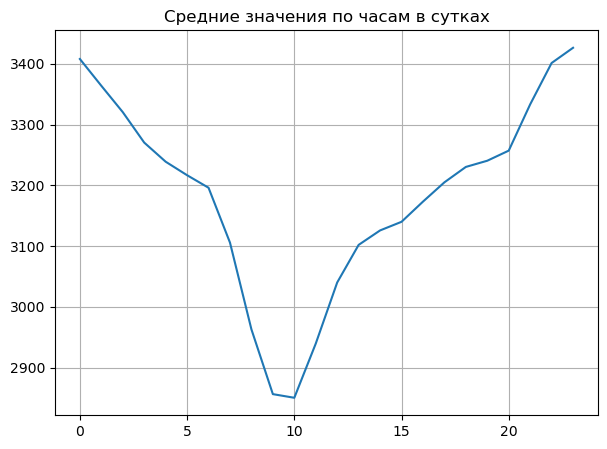

In [11]:
average_hour = code_mean(df, 'hour', "y")
plt.figure(figsize=(7, 5))
plt.title("Средние значения по часам в сутках")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);
plt.show()

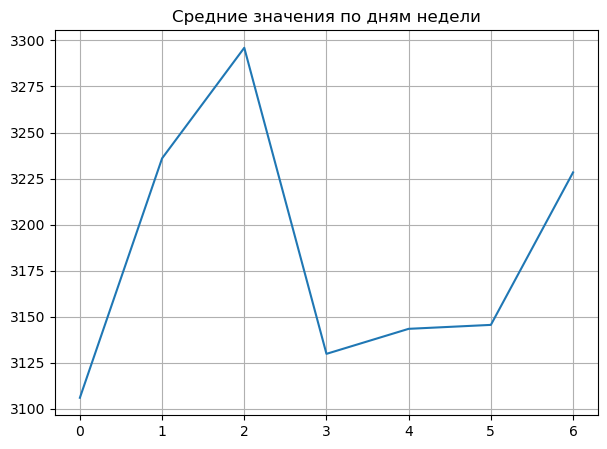

In [12]:
average_weekday = code_mean(df, 'weekday', "y")
plt.figure(figsize=(7, 5))
plt.title("Средние значения по дням недели")
pd.DataFrame.from_dict(average_weekday, orient='index')[0].plot()
plt.grid(True);
plt.show()

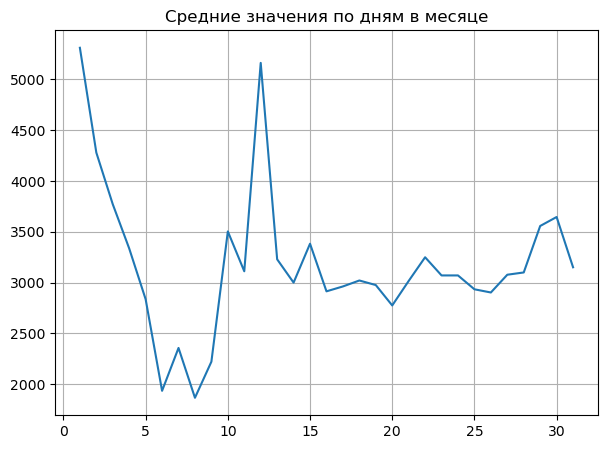

In [13]:
average_day = code_mean(df, 'day', "y")
plt.figure(figsize=(7, 5))
plt.title("Средние значения по дням в месяце")
pd.DataFrame.from_dict(average_day, orient='index')[0].plot()
plt.grid(True);
plt.show()

Здесь я решил немного сократить данные, так как их не прощитывает мой ноутбук, по этому я загрузил датасет заново и создал на его основе 2 датасета, со средними значениями за час и средними за день

In [15]:
data = pd.read_csv('data.csv')
data['dt'] = pd.to_datetime(data['dt'])

In [16]:
data_by_hour = (data.groupby(pd.Grouper(key='dt', freq='h'))['MW'].mean().reset_index(name='Avg'))
data_by_day = (data.groupby(pd.Grouper(key='dt', freq='D'))['MW'].mean().reset_index(name='Avg'))
data_by_week = (data.groupby(pd.Grouper(key='dt', freq='W'))['MW'].mean().reset_index(name='Avg'))

In [17]:
data_by_hour.head()

,dt,Avg
0,2011-01-01 00:00:00,4512.25
1,2011-01-01 01:00:00,5240.25
2,2011-01-01 02:00:00,5630.25
3,2011-01-01 03:00:00,6017.75
4,2011-01-01 04:00:00,6357.00


In [18]:
data_by_day.head()

,dt,Avg
0,2011-01-01,5398.218750
1,2011-01-02,865.385417
2,2011-01-03,761.406250
3,2011-01-04,3922.979167
4,2011-01-05,2256.239583


In [19]:
data_by_week.head()

,dt,Avg
0,2011-01-02,3131.802083
1,2011-01-09,1686.089286
2,2011-01-16,2531.937500
3,2011-01-23,930.075893
4,2011-01-30,1017.114583


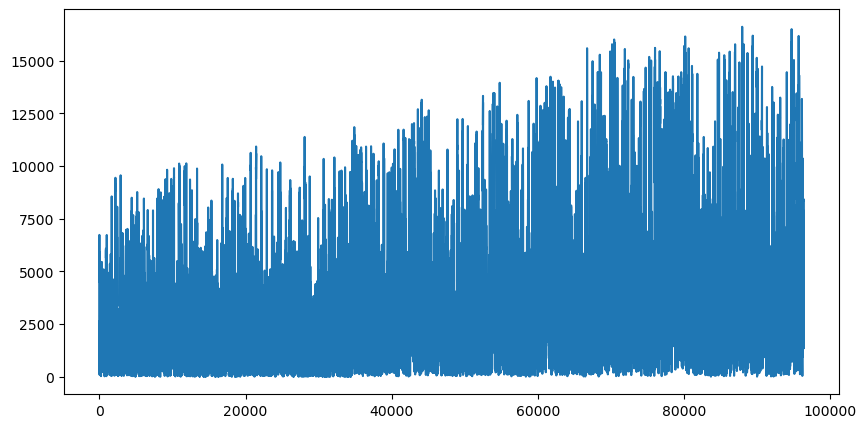

In [20]:
data_by_hour.Avg.plot(figsize=(10, 5));

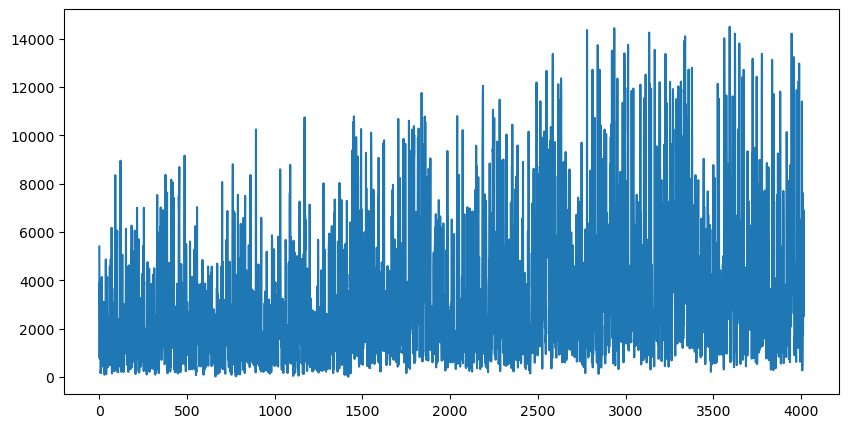

In [21]:
data_by_day.Avg.plot(figsize=(10, 5));

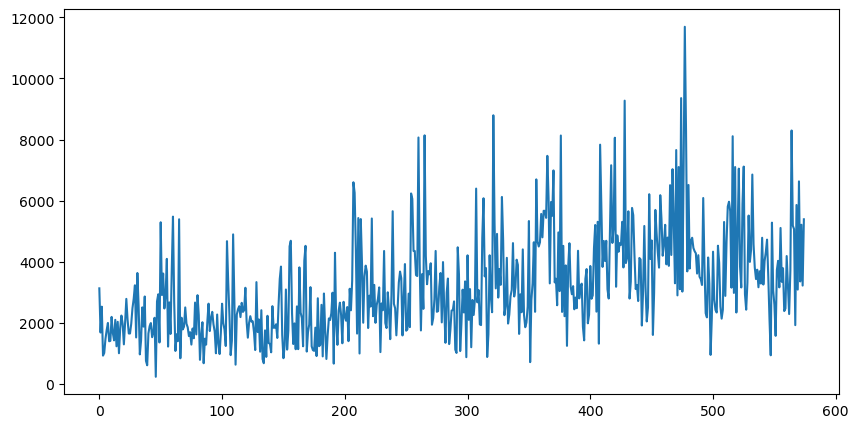

In [22]:
data_by_week.Avg.plot(figsize=(10, 5));

После подсчёта средних значений ряд становится всё менее шумный. Смею предположить, что данные преобразования помогут выделить тенденции по добыче энергии. В частности недельный ряд вполне читаем и отражает некоторые тенденции.

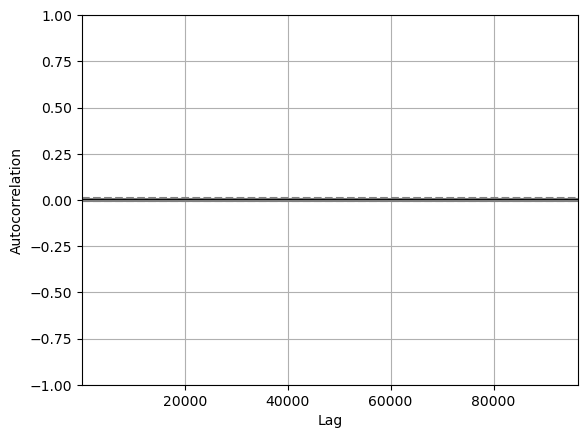

In [24]:
autocorrelation_plot(data_by_hour['Avg'])
plt.show()

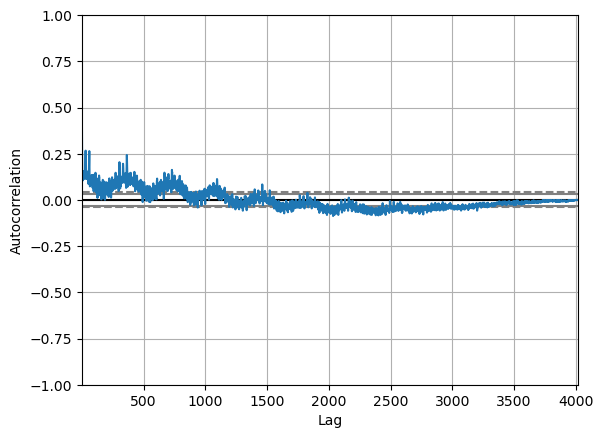

In [25]:
autocorrelation_plot(data_by_day['Avg'])
plt.show()

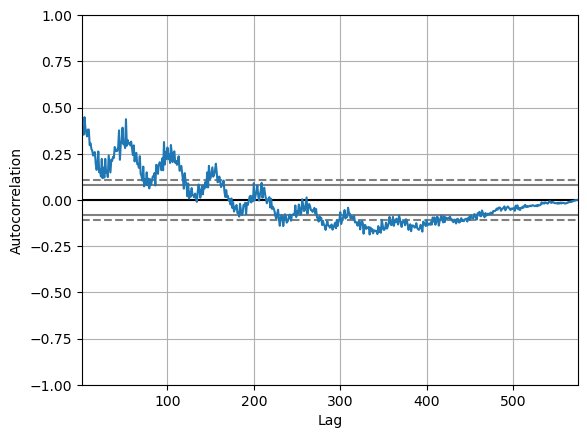

In [26]:
autocorrelation_plot(data_by_week['Avg'])
plt.show()

Для анализа временного ряда сделаем преобразование

In [28]:
data_by_day_p = pd.DataFrame(data=list(data_by_day['Avg']), index=list(data_by_day['dt']))
data_by_day_p.columns = ['avg']
data_by_week_p = pd.DataFrame(data=list(data_by_week['Avg']), index=list(data_by_week['dt']))
data_by_week_p.columns = ['avg']

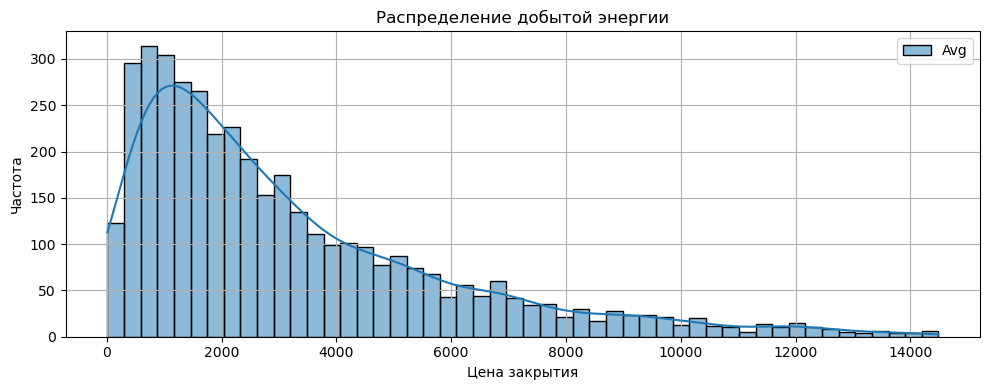

Results of Dickey-Fuller Test:
Test Statistic                   -5.232393
p-value                           0.000008
#Lags Used                       31.000000
Number of Observations Used    3985.000000
Critical Value (1%)              -3.431992
Critical Value (5%)              -2.862266
Critical Value (10%)             -2.567156
dtype: float64


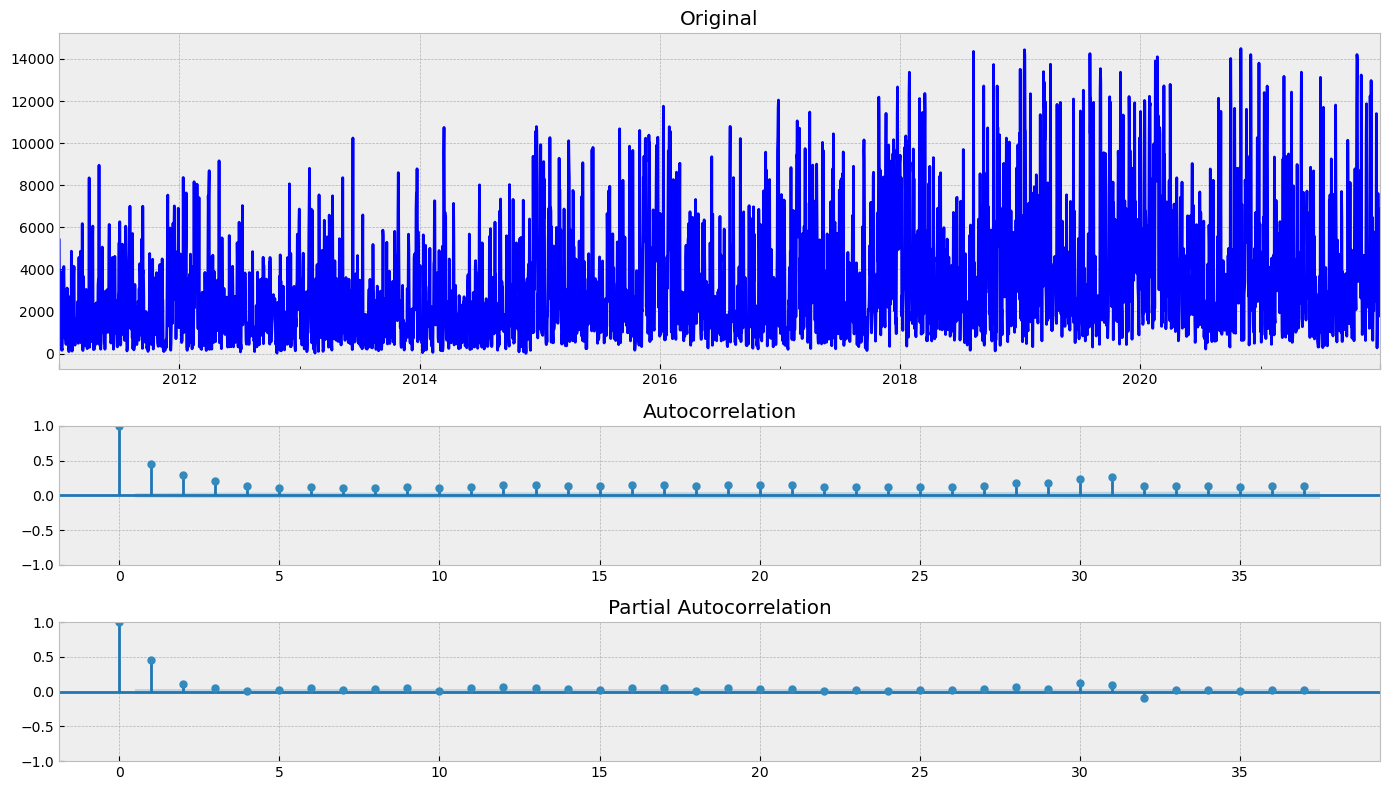

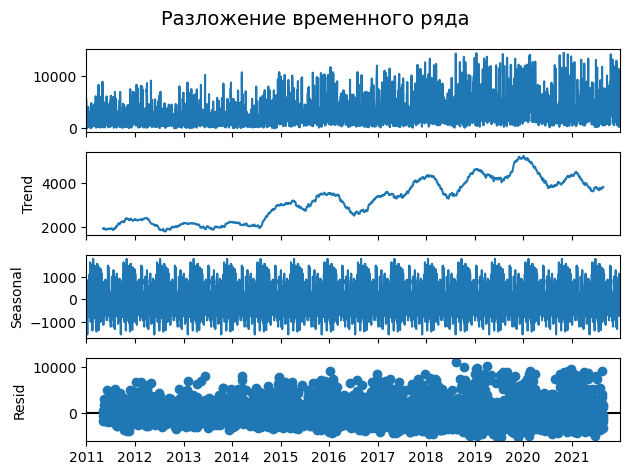

In [29]:
plt.figure(figsize=(10, 4))
sns.histplot(data_by_day, kde=True, bins=50)
plt.title('Распределение добытой энергии')
plt.xlabel('Цена закрытия')
plt.ylabel('Частота')
plt.grid(True)
plt.tight_layout()
plt.show()

# Тест на стационарность (ADF)
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

tsplot(data_by_day_p['avg'])

decomposition = seasonal_decompose(data_by_day_p, model='additive', period=252)
decomposition.plot()
plt.suptitle("Разложение временного ряда", fontsize=14)
plt.tight_layout()
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -3.015418
p-value                          0.033479
#Lags Used                       8.000000
Number of Observations Used    566.000000
Critical Value (1%)             -3.441956
Critical Value (5%)             -2.866660
Critical Value (10%)            -2.569497
dtype: float64


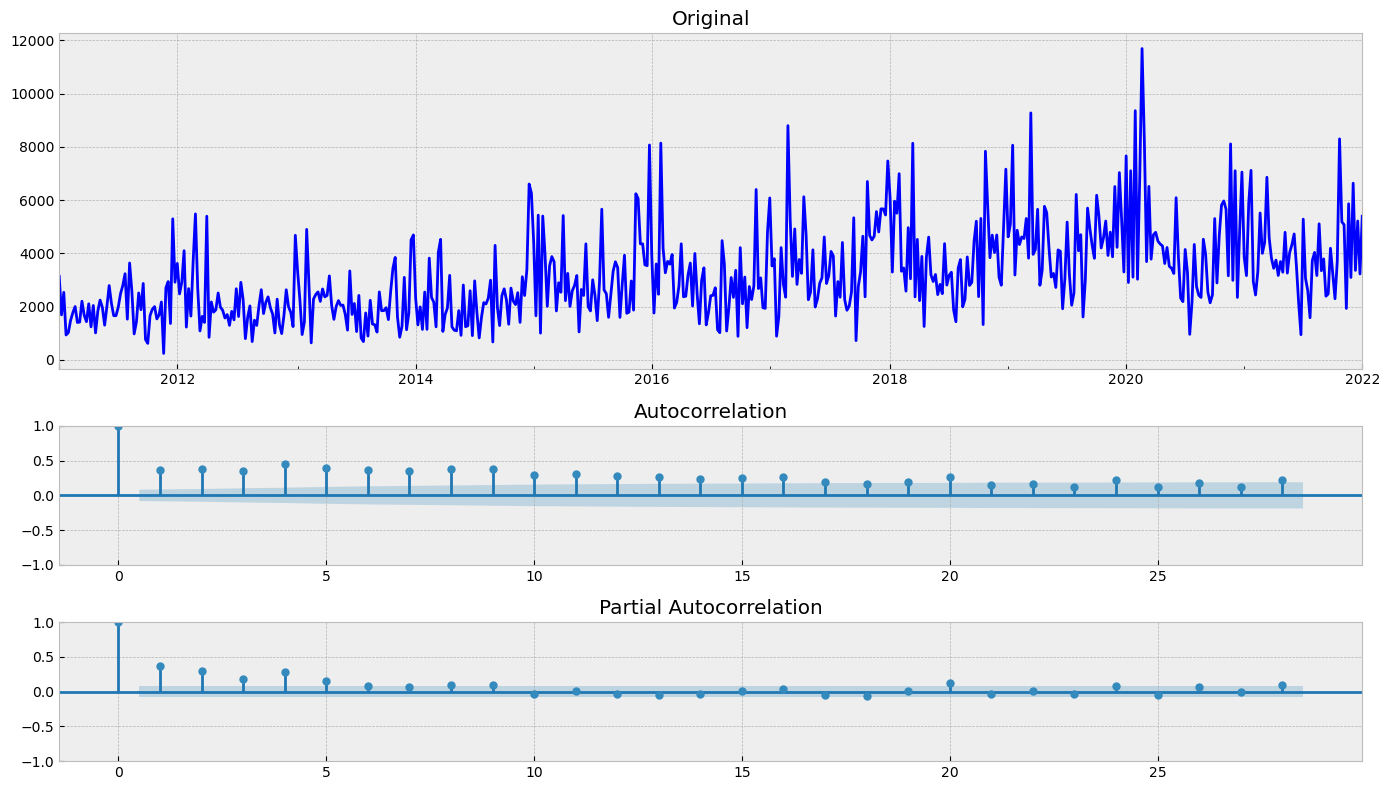

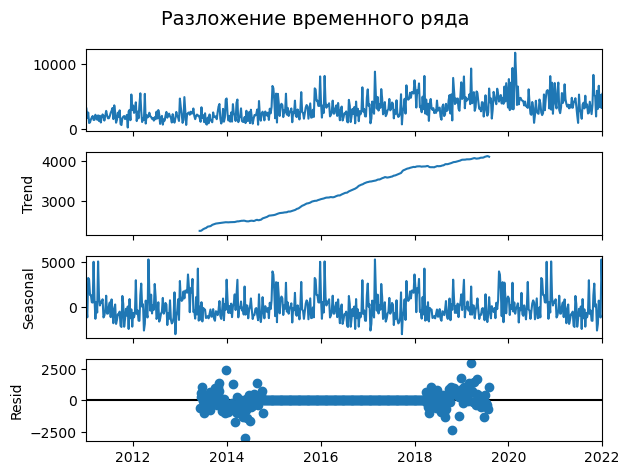

In [30]:
tsplot(data_by_week_p['avg'])

decomposition = seasonal_decompose(data_by_week_p, model='additive', period=252)
decomposition.plot()
plt.suptitle("Разложение временного ряда", fontsize=14)
plt.tight_layout()
plt.show()

Временной ряд проходит тест Дики-Фуллера на стационарность, следовательно ряд стационарен. В недельном среднем видим небольшую автокорреляцию. 

Пробуем применить Prophet для прогнозирования

In [33]:
from prophet import Prophet

In [34]:
data_by_day.columns = ['ds', 'y']
data_by_week.columns = ['ds', 'y']
data_by_day.head(5)

,ds,y
0,2011-01-01,5398.218750
1,2011-01-02,865.385417
2,2011-01-03,761.406250
3,2011-01-04,3922.979167
4,2011-01-05,2256.239583


In [35]:
predictions = 100
train_df = data_by_day[:-predictions]

In [36]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(train_df)

future = model.make_future_dataframe(periods=predictions, freq='D')
future.tail()

18:56:37 - cmdstanpy - INFO - Chain [1] start processing
18:56:38 - cmdstanpy - INFO - Chain [1] done processing


,ds
4012,2021-12-26
4013,2021-12-27
4014,2021-12-28
4015,2021-12-29
4016,2021-12-30


In [37]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
4012,2021-12-26,4171.176768,2639.119486,8977.809043,4167.980935,4173.995774,1652.297909,1652.297909,1652.297909,67.269764,67.269764,67.269764,1585.028145,1585.028145,1585.028145,0.0,0.0,0.0,5823.474677
4013,2021-12-27,4171.049387,2396.666785,8823.744609,4167.784166,4173.919229,1532.217870,1532.217870,1532.217870,-55.848775,-55.848775,-55.848775,1588.066645,1588.066645,1588.066645,0.0,0.0,0.0,5703.267258
4014,2021-12-28,4170.922007,2547.562220,9045.305182,4167.477752,4173.876917,1653.916569,1653.916569,1653.916569,75.091637,75.091637,75.091637,1578.824932,1578.824932,1578.824932,0.0,0.0,0.0,5824.838576
4015,2021-12-29,4170.794627,2709.783103,9003.968763,4167.270223,4173.804984,1661.045906,1661.045906,1661.045906,103.673695,103.673695,103.673695,1557.372212,1557.372212,1557.372212,0.0,0.0,0.0,5831.840533
4016,2021-12-30,4170.667247,2322.908642,9091.412816,4167.068701,4173.726382,1436.346723,1436.346723,1436.346723,-87.670907,-87.670907,-87.670907,1524.017631,1524.017631,1524.017631,0.0,0.0,0.0,5607.013970


Mean absolute percentage error 114.48%


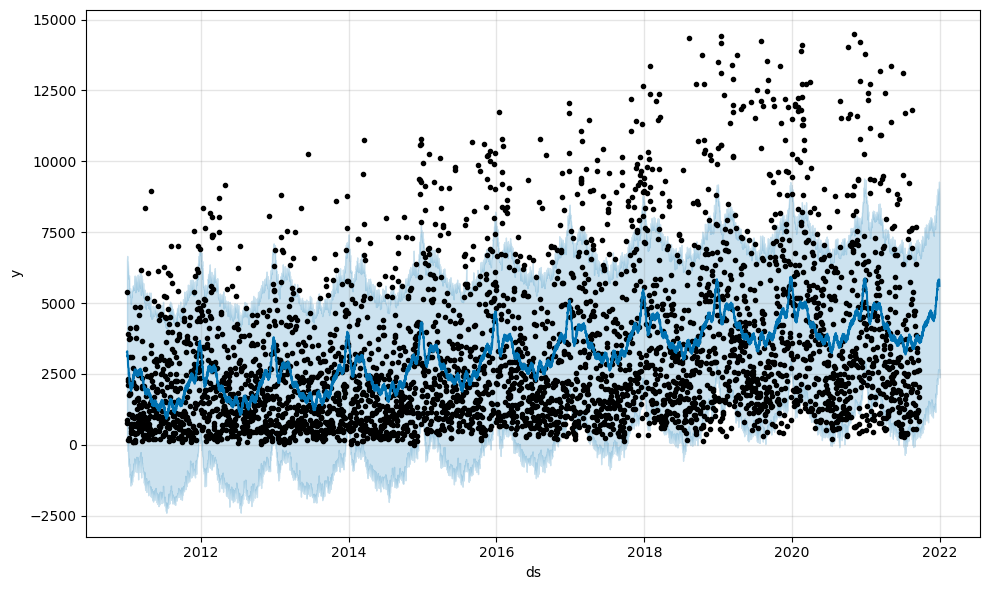

In [38]:
error = mean_absolute_percentage_error(data_by_day[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
forecast = model.predict(future)
_ = model.plot(forecast)
plt.show()

Пробуем сделать предсказание на год вперёд

18:56:38 - cmdstanpy - INFO - Chain [1] start processing
18:56:39 - cmdstanpy - INFO - Chain [1] done processing


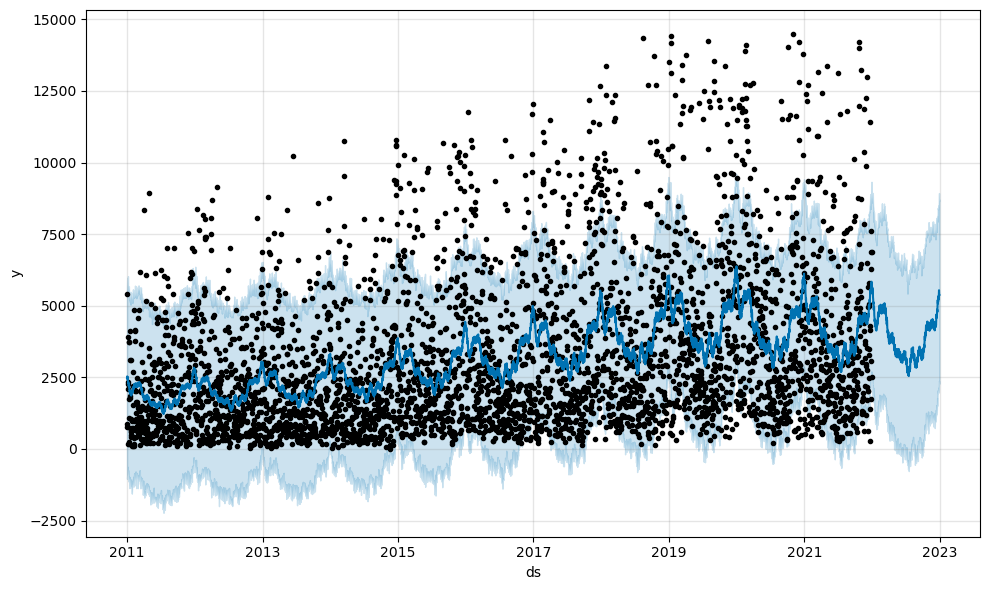

In [40]:
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, 
                weekly_seasonality = True, 
                daily_seasonality = True)
model.fit(data_by_day)
future = model.make_future_dataframe(periods=365,
                                     freq='d')

future_year = model.make_future_dataframe(periods=365, freq='d')
forecast_year = model.predict(future_year)
model.plot(forecast_year)
plt.show()

18:56:39 - cmdstanpy - INFO - Chain [1] start processing
18:56:39 - cmdstanpy - INFO - Chain [1] done processing


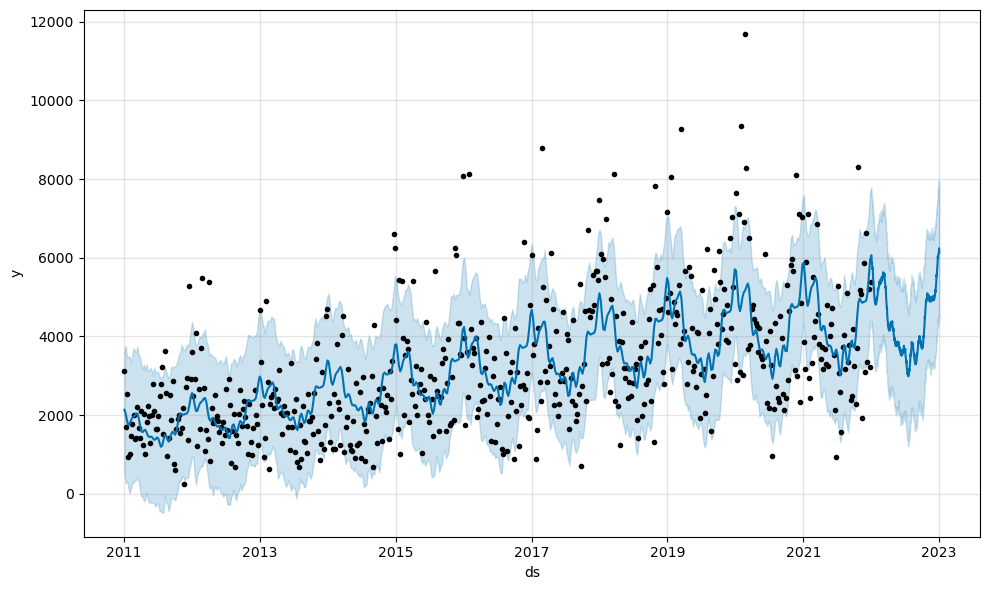

In [41]:
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, 
                weekly_seasonality = True, 
                daily_seasonality = True)
model.fit(data_by_week)
future = model.make_future_dataframe(periods=365,
                                     freq='d')

future_year = model.make_future_dataframe(periods=365, freq='d')
forecast_year = model.predict(future_year)
model.plot(forecast_year)
plt.show()

# Выводы.
```
Пришлось провести некоторые преобразования, из-за большого количества данных, самым эффективным преобразованием, на мой взгяд, было преобразование по неделям. Ряд, согласно теста Дики-Фуллера - стационарный. На графиках разложения временных рядов присутствует сезонность, а так же восходящий тренд.

Для прогноза использовалась модель Prophet, так как она показала себя достаточно неплохой и быстрой.

Модель уловила общий тренд на производство энергии. Однако можно заметить, что MAPE 114.48% на отложенных данных(по дням), можно предположить, что данный показатель так высок из-за высокой дисперсии.

А вот недельный прогноз достаточно не плох. Да, по графику видно, что есть выбросы, которые модель не может предсказать, однако общие тенденции читаются.